In [1]:
from aegis.optim import perform_optimisation
from aegis.test_problems.synthetic_problems import Forrester
from aegis.time_dists import *
from aegis.batch import BatchTS
from aegis.gen_training_data import generate_training_data_LHS

n_workers = 5
prob_function = Forrester
time_functions = {"const":consttime(),
                  "gauss":gausstime(prob_function(), scale=0.1),
                  "corr":corrtime(prob_function()),
                  "negcorr":negcorrtime(prob_function())}
time_function = time_functions["negcorr"]
acq_function = BatchTS
#acq_params = {"epsilon":0.1, "eta":0.1, "n_workers":n_workers, "n_features":2000}
acq_params = {}

problem_dim = prob_function().dim
acq_params = {
        "n_opt_samples": problem_dim * 1000,
        "n_opt_bfgs": 10,
    }

generate_training_data_LHS(prob_function, n_exp_start=1, n_exp_end=1)

perform_optimisation(prob_function, {}, 1, 50, n_workers, acq_function, acq_params, time_function)

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File exists, skipping: data/Forrester_001.pt
Loading saved run
results/async_negcorr_50_workers=5_BatchTS_Forrester_run=001.pt
Training data shape: torch.Size([50, 1])
Finished run


[Text(0.5, 1.0, 'Problem Function')]

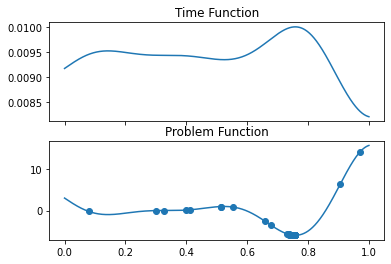

In [4]:
import matplotlib.pyplot as plt
import torch
import aegis.util as util

prob_function = Forrester
time_functions = {"const":consttime(),
                  "gauss":gausstime(prob_function(), scale=0.1),
                  "corr":corrtime(prob_function()),
                  "negcorr":negcorrtime(prob_function())}

time_function = time_functions["negcorr"]

fig, axs = plt.subplots(2, sharex='all')

prob_function = prob_function()

x = np.arange(prob_function.lb, prob_function.ub, 0.001)
axs[0].plot(x, time_function(x))
axs[0].set(title="Time Function")

data = torch.load("results/async_negcorr_50_workers=5_BatchTS_Forrester_run=001.pt")
X = data["Xtr"]
Y = data["Ytr"]

axs[1].plot(x, prob_function(x))
axs[1].scatter(X,Y)
axs[1].set(title="Problem Function")


In [ ]:
## Create a gp here and figure out how to get the variance/std deviation and mean from it, based on the above data